<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg" />
    
**<center>[mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course** </center><br>
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). [mlcourse.ai](https://mlcourse.ai) is powered by [OpenDataScience (ods.ai)](https://ods.ai/) © 2017—2022

# <center>Assignment #6. Solution</center><a class="tocSkip">
## <center> Beating benchmarks in "How good is your Medium article?"</center><a class="tocSkip">
    
[Competition](https://www.kaggle.com/c/how-good-is-your-medium-article). The task is to beat "Assignment 6 baseline". You can refer to [this simple Ridge baseline](https://www.kaggle.com/kashnitsky/ridge-countvectorizer-baseline?rvi=1).

-----

In [1]:
import json
import os
import pickle
from zipfile import ZipFile
from datetime import datetime
from glob import glob

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Lasso, Ridge, RidgeCV, SGDRegressor
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm

The following code will help to throw away all HTML tags from an article content.

In [4]:
from html.parser import HTMLParser


class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.fed = []

    def handle_data(self, d):
        self.fed.append(d)

    def get_data(self):
        return "".join(self.fed)


def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Supplementary function to read a JSON line without crashing on escape characters.

In [8]:
def read_json_line(line=None):
    result = None
    try:
        result = json.loads(line)
    except Exception as e:
        # Find the offending character index:
        idx_to_replace = int(str(e).split(" ")[-1].replace(")", ""))
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = " "
        new_line = "".join(new_line)
        return read_json_line(line=new_line)
    return result

Parse JSON and extract some features.

In [9]:
def extract_features_and_write(path_to_data, inp_filename, is_train=True):

    features = ["content", "published", "title", "author"]
    prefix = "train" if is_train else "test"
    feature_files = [
        open(
            os.path.join(path_to_data, "{}_{}.txt".format(prefix, feat)),
            "w",
            encoding="utf-8",
        )
        for feat in features
    ]

    with open(
        os.path.join(path_to_data, inp_filename), encoding="utf-8"
    ) as inp_json_file:

        for line in tqdm(inp_json_file):
            json_data = read_json_line(line)
            for i, feat in enumerate(features):
                if feat == "published":
                    info = json_data[feat]["$date"]
                elif feat == "author":
                    info = json_data[feat]["twitter"]
                    if info:
                        info = info.replace("\n", " ").replace("@", " ")
                    else:
                        info = ""
                elif feat == "content" or feat == "title":
                    info = json_data[feat].replace("\n", " ").replace("\r", " ")
                    info = strip_tags(info)
                feature_files[i].write(info + "\n")

Download the [competition data](https://www.kaggle.com/c/how-good-is-your-medium-article/data) and place it where it's convenient for you. You can modify the path to data below.

In [10]:
DATA_FOLDER = '../../data/'
DATA_ZIP_FILE = 'how-good-is-your-medium-article.zip'
TEMP_FOLDER = 'temp/'
PATH_TO_DATA = DATA_FOLDER + TEMP_FOLDER

In [11]:
# loading the data.zip and creating a zip object 
with ZipFile(
    os.path.join(DATA_FOLDER, DATA_ZIP_FILE),
    "r"
) as zObject: 
  
    # Extracting all the members of the zip  
    # into a specific temporary location
    zObject.extractall( 
        path=os.path.join(DATA_FOLDER, TEMP_FOLDER)
    ) 

In [12]:
%%time
extract_features_and_write(PATH_TO_DATA, "train.json", is_train=True)

0it [00:00, ?it/s]

CPU times: user 3min 46s, sys: 14.1 s, total: 4min
Wall time: 3min 59s


In [13]:
%%time
extract_features_and_write(PATH_TO_DATA, "test.json", is_train=False)

0it [00:00, ?it/s]

CPU times: user 2min 21s, sys: 11.3 s, total: 2min 32s
Wall time: 2min 32s


In [14]:
# Listing the files in temporary folder
files = [
    os.path.basename(file).split("data/")[0] for file in glob(
        os.path.join(
            DATA_FOLDER,
            TEMP_FOLDER,
            "*"
        )
    )
]

**Tf-Idf with article content.**

In [15]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100000)

In [16]:
%%time
with open(
    os.path.join(PATH_TO_DATA, "train_content.txt"), encoding="utf-8"
) as input_train_file:
    X_train_content_sparse = tfidf_vectorizer.fit_transform(input_train_file)

with open(
    os.path.join(PATH_TO_DATA, "test_content.txt"), encoding="utf-8"
) as input_test_file:
    X_test_content_sparse = tfidf_vectorizer.transform(input_test_file)

CPU times: user 10min 23s, sys: 24.5 s, total: 10min 48s
Wall time: 10min 47s


In [17]:
X_train_content_sparse.shape, X_test_content_sparse.shape

((62313, 100000), (34645, 100000))

**Tf-Idf with titles.**

In [19]:
%%time
tfidf_vectorizer_title = TfidfVectorizer(ngram_range=(1, 3), max_features=100000)

with open(
    os.path.join(PATH_TO_DATA, "train_title.txt"), encoding="utf-8"
) as input_train_file:
    X_train_title_sparse = tfidf_vectorizer_title.fit_transform(input_train_file)

with open(
    os.path.join(PATH_TO_DATA, "test_title.txt"), encoding="utf-8"
) as input_test_file:
    X_test_title_sparse = tfidf_vectorizer_title.transform(input_test_file)

CPU times: user 8.03 s, sys: 37.3 ms, total: 8.07 s
Wall time: 8.07 s


In [20]:
X_train_title_sparse.shape, X_test_title_sparse.shape

((62313, 100000), (34645, 100000))

**Add time features.**

In [21]:
def add_time_features(path_to_publication_time_file):

    df = pd.read_csv(path_to_publication_time_file, names=["time"])
    df["time"] = df["time"].apply(
        lambda t: pd.to_datetime(t.replace("T", " ").replace("Z", ""))
    )
    df["hour"] = df["time"].apply(lambda ts: ts.hour)
    df["month"] = df["time"].apply(lambda ts: ts.month)

    df["weekend"] = (
        df["time"]
        .apply(lambda ts: ts.weekday() == 5 or ts.weekday() == 6)
        .astype("int")
    )

    df["day"] = ((df["hour"] >= 12) & (df["hour"] <= 18)).astype("int")
    df["morning"] = ((df["hour"] >= 7) & (df["hour"] <= 11)).astype("int")
    df["night"] = ((df["hour"] >= 0) & (df["hour"] <= 5)).astype("int")

    cols = ["day", "morning", "night", "month", "weekend"]
    X_time_features_sparse = csr_matrix(df[cols].values)

    return X_time_features_sparse

In [22]:
%%time
X_train_time_features_sparse = add_time_features(
    os.path.join(PATH_TO_DATA, "train_published.txt")
)
X_test_time_features_sparse = add_time_features(
    os.path.join(PATH_TO_DATA, "test_published.txt")
)

CPU times: user 1min 4s, sys: 21.8 ms, total: 1min 4s
Wall time: 1min 4s


In [29]:
X_train_time_features_sparse.shape, X_test_time_features_sparse.shape

((62313, 5), (34645, 5))

**Add authors.**

In [24]:
%%time
author_train = pd.read_csv(
    os.path.join(PATH_TO_DATA, "train_author.txt"),
    names=["author"],
    skip_blank_lines=False,
)
author_train = pd.get_dummies(author_train)

author_test = pd.read_csv(
    os.path.join(PATH_TO_DATA, "test_author.txt"),
    names=["author"],
    skip_blank_lines=False,
)
author_test = pd.get_dummies(author_test)

unique_authors_train = list(set(author_train.columns) - set(author_test.columns))
unique_authors_test = list(set(author_test.columns) - set(author_train.columns))

author_test = author_test.drop(unique_authors_test, axis=1)
author_train = author_train.drop(unique_authors_train, axis=1)

X_train_author_sparse = csr_matrix(author_train.values)
X_test_author_sparse = csr_matrix(author_test.values)

CPU times: user 21.9 s, sys: 2.62 s, total: 24.5 s
Wall time: 24.5 s


In [25]:
X_train_author_sparse.shape, X_test_author_sparse.shape

((62313, 4587), (34645, 4587))

**Join all sparse matrices.**

In [26]:
X_train_sparse = hstack(
    [
        X_train_content_sparse,
        X_train_title_sparse,
        X_train_author_sparse,
        X_train_time_features_sparse,
    ]
).tocsr()

In [27]:
X_test_sparse = hstack(
    [
        X_test_content_sparse,
        X_test_title_sparse,
        X_test_author_sparse,
        X_test_time_features_sparse,
    ]
).tocsr()

In [30]:
X_train_sparse.shape, X_test_sparse.shape

((62313, 204592), (34645, 204592))

**Read train target and split data for validation.**

In [31]:
train_target = pd.read_csv(
    os.path.join(PATH_TO_DATA, "train_log1p_recommends.csv"), index_col="id"
)
y_train = train_target["log_recommends"].values

In [32]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part_sparse = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid_sparse = X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

**Train a simple Ridge model and check MAE on the validation set.**

In [33]:
%%time
ridge_reg = Ridge(random_state=17)
ridge_reg.fit(X_train_part_sparse, y_train_part)
ridge_valid_pred = ridge_reg.predict(X_valid_sparse)
print(mean_absolute_error(y_valid, ridge_valid_pred))

1.1032474166060544
CPU times: user 3min 48s, sys: 2.09 s, total: 3min 50s
Wall time: 1min 7s


Plot distributions of tagets and predictions for the validation set.

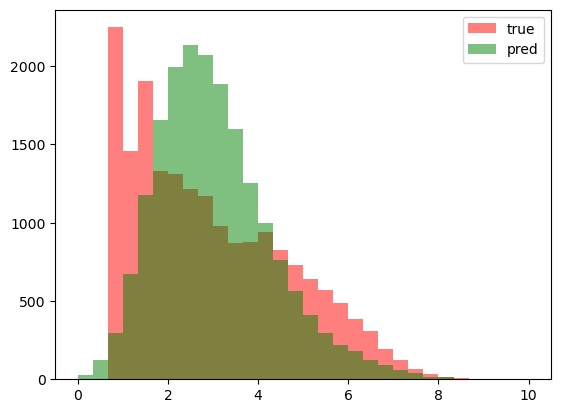

In [34]:
plt.hist(y_valid, bins=30, alpha=0.5, color="red", label="true", range=(0, 10))
plt.hist(
    ridge_valid_pred, bins=30, alpha=0.5, color="green", label="pred", range=(0, 10)
)
plt.legend();

**Train the same Ridge with all available data, make predictions for the test set and form a submission file.**

In [35]:
%%time
ridge_reg.fit(X_train_sparse, y_train)
ridge_test_pred = ridge_reg.predict(X_test_sparse)

CPU times: user 4min 57s, sys: 3.38 s, total: 5min
Wall time: 1min 47s


In [36]:
def write_submission_file(
    prediction,
    filename,
    path_to_sample=os.path.join(PATH_TO_DATA, "sample_submission.csv"),
):
    submission = pd.read_csv(path_to_sample, index_col="id")

    submission["log_recommends"] = prediction
    submission.to_csv(filename)

In [37]:
write_submission_file(
    ridge_test_pred, os.path.join(PATH_TO_DATA, "assignment6_medium_submission.csv")
)

**With this you get ~ 1.73877 on public leaderboard.**

**Now's the time for dirty Kaggle hacks. Form a submission file with all zeroes. Make a submission. What do you get if you think about? How is it going to help you with modifying your predictions?**

In [38]:
write_submission_file(
    np.zeros_like(ridge_test_pred),
    os.path.join(PATH_TO_DATA, "medium_all_zeros_submission.csv"),
)

In [39]:
mean_test_target = 4.33328

**Calculate mean target for the test set.**

In [40]:
y_train.mean()

3.051538598205832

**Now we now that we need to add the difference between test and train mean targets.**

In [41]:
ridge_test_pred_modif = ridge_test_pred + mean_test_target - y_train.mean()

In [42]:
write_submission_file(
    ridge_test_pred_modif,
    os.path.join(PATH_TO_DATA, "assignment6_medium_submission_with_hack.csv"),
)

That's it for the assignment. In case you'd like to try some more ideas for improvement:

- Engineer good features, this is the key to success. Some simple features will be based on publication time, authors, content length and so on
- You may not ignore HTML and extract some features from there
- You'd better experiment with your validation scheme. You should see a correlation between your local improvements and LB score
- Try TF-IDF, ngrams, Word2Vec and GloVe embeddings
- Try various NLP techniques like stemming and lemmatization
- Tune hyperparameters. In our example, we've left only 50k features and used C=1 as a regularization parameter, this can be changed
- SGD and Vowpal Wabbit will train much faster
- Play around with blending and/or stacking. An intro is given in [this Kernel](https://www.kaggle.com/kashnitsky/ridge-and-lightgbm-simple-blending) by @yorko 
- And neural nets of course. We don't cover them in this course byt still transformer-based architectures will likely perform well in such types of tasks

In [44]:
# Deleting temporary files
for file in files:
    try:
        os.remove(os.path.join(DATA_FOLDER, TEMP_FOLDER, file))
    except:
        print(f"{file} does not exist")

# Deleting temporary folder
try:
    os.rmdir(os.path.join(DATA_FOLDER, TEMP_FOLDER))
except:
    print("Folder does not exist")

train.json.gz does not exist
test_author.txt does not exist
test_title.txt does not exist
train_published.txt does not exist
test_published.txt does not exist
train_title.txt does not exist
test.json does not exist
test_content.txt does not exist
train.json does not exist
test.json.gz does not exist
sample_submission.csv does not exist
test_log1p_recommends.csv does not exist
train_content.txt does not exist
train_log1p_recommends.csv does not exist
train_author.txt does not exist
Folder does not exist
